# GTFS Data Analysis

In [16]:
# Necessary imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import json
import datetime
import re
import math
from geopy.distance import geodesic
import logging
import matplotlib.pyplot as plt
import scipy.stats as stats

Select a railroad:

In [17]:
railroad = "mnrr"

Gather data

In [18]:
df = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')
df = df[['stop_name','stop_lat','stop_lon']]

df_ref = pd.read_csv(f'../data/csv/{railroad}.csv')
row_stop_counts = df_ref.drop(columns=["stop_name","Unnamed: 0"]).notna().sum(axis=1)
df['counts'] = row_stop_counts
df = df.sort_values(by='counts',ascending=False).reset_index(drop=True)

Draw stop frequency map (all day)

In [19]:
fig = px.scatter_mapbox(
    df,
    lat="stop_lat",
    lon="stop_lon",
    hover_name="stop_name",
    color="counts", 
    color_continuous_scale="Viridis",
    range_color=[0, df["counts"].max()],
    zoom=10  # Optional, depending on how zoomed in you want
)

fig.update_layout(
    mapbox_style="carto-darkmatter",  # This is the correct property
    margin={"r":0, "t":0, "l":0, "b":0}
)

fig.show()


In [20]:
with open(f'../data/json/data{railroad}.json', 'r') as file:
    train_list = json.load(file)
    if (len(train_list) <= 0):
        print(f"\tWarning! Empty List.")
        print(f"\tNumber of trains: 0")

In [21]:
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')

train_lines = sorted(list({train["train_line"] for train in train_list}))
graph_for_lines = {}
for train_line in train_lines:
    total_train_in_route = sum(1 for train in train_list if train["train_line"] == train_line)
    graph_for_lines[train_line] = total_train_in_route

graph_for_lines = pd.DataFrame(list(graph_for_lines.items()), columns=["train_line", "value"])

df_colors['train_line'] = df_colors['route_long_name']
graph_for_lines = graph_for_lines.merge(df_colors, on='train_line')

fig = px.pie(graph_for_lines, names='train_line', values='value', color='train_line', color_discrete_map=dict(zip(graph_for_lines['train_line'], graph_for_lines['route_color'])))
fig.update_traces(textinfo='label+percent',
                   marker=dict(line=dict(color='black', width=2)))

fig.show()


In [22]:
num_stops = []
binned_times = {
    "4-10" : 0,
    "10-16" : 0,
    "16-22" : 0,
    "22-4": 0
}
hourly_times = {}
hourly_times_arriving = {}
for train in train_list:
    df = pd.DataFrame(train['stops']).transpose()
    df_cleaned = df[df['departure_time'] != 'n/a']
    df_cleaned.loc[:, 'stop_index'] = df_cleaned['stop_index'].astype(int)
    df_cleaned = df_cleaned.sort_values(by='stop_index')

    timeA = df_cleaned.iloc[0].departure_time
    timeB = df_cleaned.iloc[len(df_cleaned)-1].departure_time


    timeA = f'1900-01-{1+(int(timeA[:timeA.find(":")])//24)} {int(timeA[:timeA.find(":")])%24}:{timeA[timeA.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeA) else f'1900-01-01 {timeA}'
    timeB = f'1900-01-{1+(int(timeB[:timeB.find(":")])//24)} {int(timeB[:timeB.find(":")])%24}:{timeB[timeB.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeB) else f'1900-01-01 {timeB}'
    timeA = datetime.datetime.strptime(timeA, '%Y-%m-%d %H:%M:%S')
    timeB = datetime.datetime.strptime(timeB, '%Y-%m-%d %H:%M:%S')
    
    binned_times[list(binned_times.keys())[math.floor((timeA.hour-4)/6)]] = binned_times[list(binned_times.keys())[math.floor((timeA.hour-4)/6)]] + 1
    
    if f'{timeA.hour}' in hourly_times:
        hourly_times[f'{timeA.hour}'][int(train['direction_id'])] = hourly_times[f'{timeA.hour}'][int(train['direction_id'])] + 1
    else:
        arr = [0, 0]
        arr[int(train['direction_id'])] = 1
        hourly_times[f'{timeA.hour}'] = arr

    if f'{timeB.hour}' in hourly_times_arriving:
        hourly_times_arriving[f'{timeB.hour}'][int(train['direction_id'])] = hourly_times_arriving[f'{timeB.hour}'][int(train['direction_id'])] + 1
    else:
        arr = [0, 0]
        arr[int(train['direction_id'])] = 1
        hourly_times_arriving[f'{timeB.hour}'] = arr

    # print(
    #     df_cleaned.iloc[len(df_cleaned)-1].name , train["direction_id"] , df_cleaned.iloc[0].name,
    #     df_cleaned.iloc[len(df_cleaned)-1].name if train["direction_id"] == "0" else df_cleaned.iloc[0].name
    #     )
    
    
    num_stops.append({
        'train_id' : train['train_number'],
        'number_of_stops': len(df_cleaned),
        'first_stop_time' : timeA,
        'last_stop_time' : timeB,
        'travel_time': int((timeB-timeA).total_seconds()),
        'distance' : train['distance'],
        'departure_station': df_cleaned.iloc[0].name,
        'arrival_station': df_cleaned.iloc[len(df_cleaned)-1].name,
        'train_line': f'{ train["train_line"]}',
        'train_label': f'{ train["train_number"]} {train["train_line"]} ({df_cleaned.iloc[0].name} - {df_cleaned.iloc[len(df_cleaned)-1].name})'
    })

In [23]:
def graphs(trip_durations):
    mean = np.mean(trip_durations)
    std_dev = np.std(trip_durations)
    med = np.median(trip_durations)
    plt.hist(trip_durations, bins=10, alpha=0.6, color='b', density=True)
    xmin, xmax = min(trip_durations), max(trip_durations)
    plt.xlim(xmin, xmax)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'Normal Distribution (mean={mean:.2f}, med={med:.2f} std_dev={std_dev:.2f})')

    return plt
    # plt.show()


	Shortest Trip (stop # wise): 4 stops on 507
	Longest Trip (stop # wise): 30 stops on 699
	On average trains make: 13 stops
	Median # of train: 13 stops


<module 'matplotlib.pyplot' from 'c:\\Users\\okayk\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

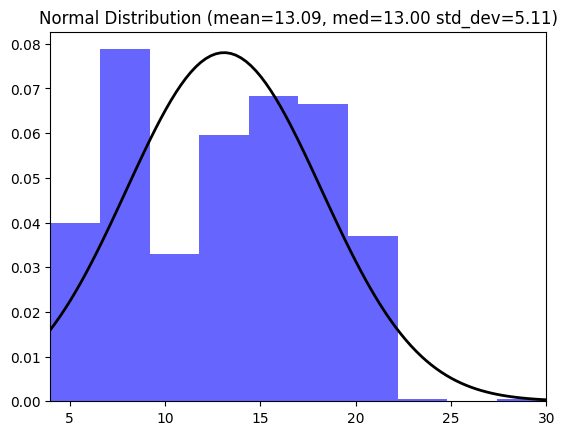

In [24]:
min_by_stops = min(num_stops, key=lambda x: x["number_of_stops"])
max_by_stops = max(num_stops, key=lambda x: x["number_of_stops"])
trip_durations = [trip['number_of_stops'] for trip in num_stops]
avg_stops = np.mean(trip_durations)
median_stops = np.median(trip_durations)
print(f'\n\tShortest Trip (stop # wise): {min_by_stops["number_of_stops"]} stops on {min_by_stops["train_id"]}')
print(f'\tLongest Trip (stop # wise): {max_by_stops["number_of_stops"]} stops on {max_by_stops["train_id"]}')
print(f'\tOn average trains make: {avg_stops:.0f} stops')
print(f'\tMedian # of train: {median_stops:.0f} stops')
graphs(trip_durations)


	Shortest Trip (distance wise): 7.3 miles on 1716
	Longest Trip (distance wise): 82.0 miles on 916
	On average trains travels: 41.7 miles
	Median travel distance: 33.0 miles


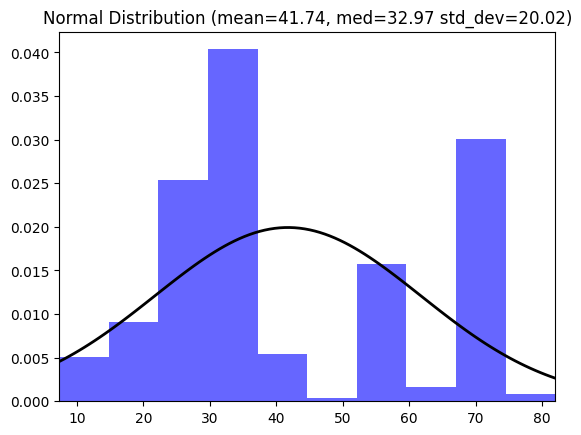

In [25]:
if (railroad != "metrolink" and railroad != "sle"):
    cleaned_data = [item for item in num_stops if item["distance"] != "NA"]
    min_by_distance = min(cleaned_data, key=lambda x: x["distance"])
    max_by_distance = max(cleaned_data, key=lambda x: x["distance"])
    trip_durations = [trip['distance'] for trip in cleaned_data]
    # graphs(trip_durations)
    avg_distance = np.mean(trip_durations)
    median_distance = np.median(trip_durations)
    print(f'\n\tShortest Trip (distance wise): {min_by_distance["distance"]:.1f} miles on {min_by_distance["train_id"]}')
    print(f'\tLongest Trip (distance wise): {max_by_distance["distance"]:.1f} miles on {max_by_distance["train_id"]}')
    print(f'\tOn average trains travels: {avg_distance:.1f} miles')
    print(f'\tMedian travel distance: {median_distance:.1f} miles')
    graphs(trip_durations) 


	Shortest Trip (time wise): 17.0 minutes on 1751
	Longest Trip (time wise): 139.0 minutes on 1575
	On average trains take: 77.1 minutes
	Median time of trips: 71.0 minutes


<module 'matplotlib.pyplot' from 'c:\\Users\\okayk\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

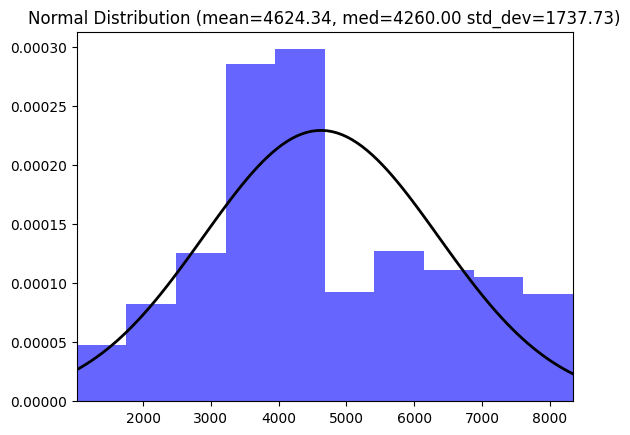

In [26]:

min_by_time = min(num_stops, key=lambda x: x["travel_time"])
max_by_time = max(num_stops, key=lambda x: x["travel_time"])
trip_durations = [trip['travel_time'] for trip in num_stops]
avg_time = np.mean(trip_durations)
median_time = np.median(trip_durations)
print(f'\n\tShortest Trip (time wise): {min_by_time["travel_time"]/60:.1f} minutes on {min_by_time["train_id"]}')
print(f'\tLongest Trip (time wise): {max_by_time["travel_time"]/60:.1f} minutes on {max_by_time["train_id"]}')
print(f'\tOn average trains take: {avg_time/60:.1f} minutes')
print(f'\tMedian time of trips: {median_time/60:.1f} minutes')
graphs(trip_durations)

In [27]:

if (railroad != "rtd"):
    # Get stops and their info
    df = pd.read_csv(f'../data/csv/{railroad}.csv') # assuming running form root
    df_ref = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')
    # df_ace = pd.read_csv(f'./gtfs_data/{ele}/shapes.txt')

    # Clean and calculate max trains per stop
    df.drop('Unnamed: 0', axis=1, inplace=True)
    row_stop_counts = df.drop(columns=["stop_name"]).notna().sum(axis=1)
    df_ref['counts'] = row_stop_counts
    df_ref = df_ref[['stop_name','counts']]
    df_ref = df_ref.sort_values(by='counts',ascending=False).iloc[0:3].reset_index(drop=True)
    print("\n\tTop three stations: ")
    for index,row in df_ref.iterrows():
        print(f'\t\t{index+1}. {row["stop_name"]} ({row["counts"]} trains)')
# graph already above



	Top three stations: 
		1. Grand Central (569 trains)
		2. Harlem-125 St (526 trains)
		3. Stamford (225 trains)



	Time frequency (leaving times): 
	4 am to 10 am: 222
	10 am to 4 pm: 153
	4 pm to 10 pm: 229
	10pm to 4 am: 60




<module 'matplotlib.pyplot' from 'c:\\Users\\okayk\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

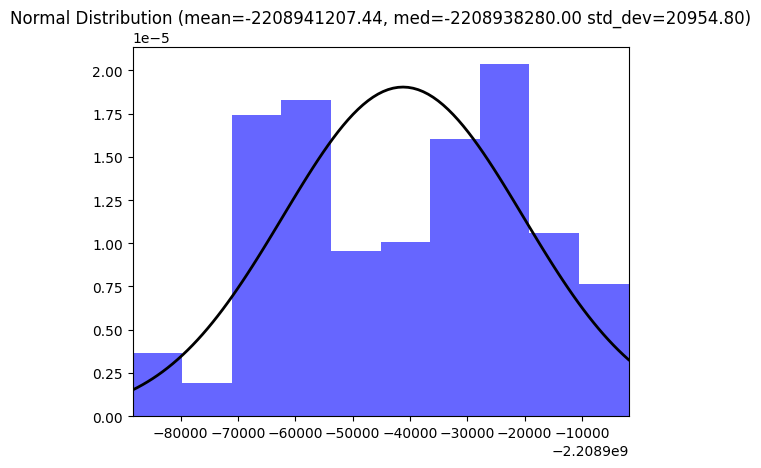

In [28]:
print("\n\tTime frequency (leaving times): ")
print(f'\t4 am to 10 am: {binned_times["4-10"]}')
print(f'\t10 am to 4 pm: {binned_times["10-16"]}')
print(f'\t4 pm to 10 pm: {binned_times["16-22"]}')
print(f'\t10pm to 4 am: {binned_times["22-4"]}')
print(f'\n')

trip_durations = [trip['first_stop_time'] for trip in num_stops]
epoch = datetime.datetime(1970, 1, 1)
seconds_list = [(dt - epoch).total_seconds() for dt in trip_durations]
graphs(seconds_list)

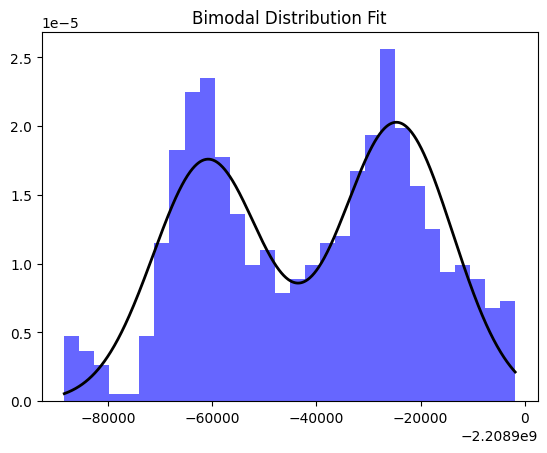

In [29]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Sample data (replace with your own data)
data = np.array(seconds_list)

# Fit a GMM with 2 components (for bimodal)
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Predict the components for each point
labels = gmm.predict(data.reshape(-1, 1))

# Visualize the result
import matplotlib.pyplot as plt
plt.hist(data, bins=30, alpha=0.6, color='b', density=True)
x = np.linspace(min(data), max(data), 1000)
p = np.exp(gmm.score_samples(x.reshape(-1, 1)))  # Calculate probability density
plt.plot(x, p, color='black', linewidth=2)
plt.title("Bimodal Distribution Fit")
plt.show()


In [30]:
hourly_times
#  hourly_times[f'{timeA.hour}_{train["direction_id"]}']
hourly_times_df = pd.DataFrame(list(hourly_times.items()), columns=["hour", "value"])


# Split the lists in the 'value' column into separate columns
df_split = hourly_times_df["value"].apply(pd.Series)

# Rename the new columns
df_split.columns = ["value_0", "value_1"]

# Concatenate the new columns back with the 'hour' column
hourly_times_df = pd.concat([hourly_times_df["hour"], df_split], axis=1)


hourly_times_df["hour"] = hourly_times_df["hour"].astype(int)
hourly_times_df['total'] = hourly_times_df['value_0'] +  hourly_times_df['value_1']
hourly_times_df.sort_values(by='hour')
hourly_times_df = hourly_times_df.set_index("hour").reindex(range(24), fill_value=0).reset_index()
fig = px.bar(hourly_times_df, 
             x="hour", 
             y=["total"],
              title="Bar Graph of Hourly Values",
              text_auto=True,
              barmode="group")

# # Show the figure
fig.show()


In [31]:
hourly_times
#  hourly_times[f'{timeA.hour}_{train["direction_id"]}']
hourly_times_df = pd.DataFrame(list(hourly_times.items()), columns=["hour", "value"])


# Split the lists in the 'value' column into separate columns
df_split = hourly_times_df["value"].apply(pd.Series)

# Rename the new columns
df_split.columns = ["value_0", "value_1"]

# Concatenate the new columns back with the 'hour' column
hourly_times_df = pd.concat([hourly_times_df["hour"], df_split], axis=1)


hourly_times_df["hour"] = hourly_times_df["hour"].astype(int)
hourly_times_df.sort_values(by='hour')
hourly_times_df = hourly_times_df.set_index("hour").reindex(range(24), fill_value=0).reset_index()
fig = px.bar(hourly_times_df, 
             x="hour", 
             y=["value_0", "value_1"],
              title="Bar Graph of Hourly Values",
              text_auto=True,
              barmode="group")

# # Show the figure
fig.show()

In [32]:

#  hourly_times[f'{timeA.hour}_{train["direction_id"]}']
hourly_times_df = pd.DataFrame(list(hourly_times_arriving.items()), columns=["hour", "value"])


# Split the lists in the 'value' column into separate columns
df_split = hourly_times_df["value"].apply(pd.Series)

# Rename the new columns
df_split.columns = ["value_0", "value_1"]

# Concatenate the new columns back with the 'hour' column
hourly_times_df = pd.concat([hourly_times_df["hour"], df_split], axis=1)


hourly_times_df["hour"] = hourly_times_df["hour"].astype(int)
hourly_times_df.sort_values(by='hour')
hourly_times_df = hourly_times_df.set_index("hour").reindex(range(24), fill_value=0).reset_index()
fig = px.bar(hourly_times_df, 
             x="hour", 
             y=["value_0", "value_1"],
              title="Bar Graph of Hourly Values",
              text_auto=True,
              barmode="group")

# # Show the figure
fig.show()


In [33]:
df = pd.DataFrame(num_stops)
df = df[df['distance'] != "NA"]
df['travel_time'] = df['travel_time'] / 60
xaxis_max = df['distance'].max() + 5
yaxis_max = df['travel_time'].max() + 5
fig = px.scatter(df, x="distance", y="travel_time", color='number_of_stops', hover_name="train_label",
                #   trendline="rolling", trendline_options=dict(window=10),
                 )
fig.update_layout(
    xaxis_range = [0,xaxis_max],
    yaxis_range = [0,yaxis_max],
    width = 1400,
    height = 700
)
fig.show()

In [34]:
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')
df_colors['train_line'] = df_colors['route_long_name']
df_colors['route_color'] = df_colors['route_color'].apply(lambda x: x if x.startswith('#') else f'#{x}')

df = pd.DataFrame(num_stops)
df = df[df['distance'] != "NA"]
df['travel_time'] = df['travel_time'] / 60
xaxis_max = df['distance'].max() + 5
yaxis_max = df['travel_time'].max() + 5


color_map = dict(zip(df_colors['route_long_name'], df_colors['route_color']))

fig = px.scatter(df, x="distance", y="travel_time", color='train_line', hover_name="train_label",
                                 color_discrete_map=color_map
                 )
fig.update_layout(
    xaxis_range = [0,xaxis_max],
    yaxis_range = [0,yaxis_max],
    width = 1400,
    height = 700
)
fig.show()

In [35]:
df = pd.DataFrame(num_stops)
df["travel_time"] = df["travel_time"] / 60  # Convert to hours
df = df[df["distance"] != "NA"]
global_min = df["number_of_stops"].min()
global_max = df["number_of_stops"].max()
xaxis_max = df['distance'].max() + 5
yaxis_max = df['travel_time'].max() + 5
# Get unique train lines
train_lines = df["train_line"].unique()

# Create traces for each train line
fig = go.Figure()

# Define the colorscale for the gradient
colorscale = px.colors.sequential.Plasma

for line in train_lines:
    filtered_df = df[df["train_line"] == line]
    fig.add_trace(
        go.Scatter(
            x=filtered_df["distance"],
            y=filtered_df["travel_time"],
            mode="markers",
            marker=dict(
                color=filtered_df["number_of_stops"], 
                colorscale=colorscale,
                cmin=global_min,  
                cmax=global_max,  
                colorbar=dict(
                    title="Number of Stops",
                ),
            ),
            name=line, 
            hovertext=filtered_df["train_label"],
            visible=True, 
        )
    )


# Add dropdown buttons
buttons = [
    dict(
        label=line,
        method="update",
        args=[
            {"visible": [line == train for train in train_lines]}, 
            {"title": f"Train Line: {line}"},
        ],
    )
    for line in train_lines
]
buttons.insert(
    0,
    dict(
        label="All",
        method="update",
        args=[
            {"visible": [True] * len(train_lines)},  
            {"title": "All Train Lines"},
        ],
    )
)

# Update layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
        )
    ],
    title="Train Line Filter with Color Gradient",
    xaxis_range = [0,xaxis_max],
    yaxis_range = [0,yaxis_max],
    xaxis_title="Distance (miles)",
    yaxis_title="Travel Time (minutes)",
    height = 700,
    showlegend=False
)

fig.show()


In [36]:
df = pd.DataFrame(num_stops)
df = df[df['distance'] != "NA"]
df['travel_time'] = df['travel_time'] / 60
xaxis_max = df['distance'].max() + 5
yaxis_max = df['travel_time'].max() + 5
fig = px.scatter_3d(df, x='distance', y='travel_time', z='number_of_stops',
                    color='number_of_stops', symbol='train_line')
fig.show()

In [37]:

if (railroad != "rtd"):
    # Get stops and their info
    df = pd.read_csv(f'../data/csv/{railroad}.csv') # assuming running form root
    df_ref = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')
    # df_ace = pd.read_csv(f'./gtfs_data/{ele}/shapes.txt')

    # Clean and calculate max trains per stop
    df.drop('Unnamed: 0', axis=1, inplace=True)
    row_stop_counts = df.drop(columns=["stop_name"]).notna().sum(axis=1)
    df_ref['counts'] = row_stop_counts
    df_ref = df_ref[['stop_name','counts']]


fig = px.bar(df_ref, x="stop_name", y=["counts"])
fig.show()

In [38]:
prev_df = pd.DataFrame()
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')

for train in train_list:
    df = pd.DataFrame(train['stops']).T.drop(['stop_index'], axis=1).rename(columns={'departure_time': f'{train["train_line"]}'})
    
    df = df.apply(lambda x: x.map(lambda val: 0 if val == 'n/a' else 1))
    
    if train["train_line"] in prev_df.columns:
        prev_df[train["train_line"]] = prev_df[train["train_line"]] + df[train["train_line"]]
    else:
        prev_df[train["train_line"]] = df[train["train_line"]]

df_colors['route_color'] = df_colors['route_color'].apply(lambda x: x if x.startswith('#') else f'#{x}')
color_map = dict(zip(df_colors['route_long_name'], df_colors['route_color']))

fig = px.bar(prev_df, 
             x=df.index, 
             y=list(prev_df.columns),
              title="Bar Graph of Hourly Values",
                color_discrete_map=color_map
            )
fig.show()

In [39]:
df = pd.read_csv(f'../data/csv/{railroad}.csv').drop('Unnamed: 0',axis=1)
df = df.set_index('stop_name')
# df = df.filter(like="Oyster Bay Branch")
df = df.notna()
df = df.T
false_columns = df.columns[~df.any(bool_only=True)]
df = df.drop(columns=false_columns)

fig = px.imshow(
    df,
    color_continuous_scale=["white", "black"],  
    title="True/False Grid Visualization"
)

fig.update_layout(
    xaxis=dict(
        tickangle=45,
        side="bottom",  
        showgrid=True
    ),
   
    coloraxis_showscale=False,  
    # width=1000,                 
    height=750,
    grid=dict(rows=2, columns=2, pattern="independent")
              
)

# Render the heatmap
fig.show()

In [40]:
df = pd.read_csv(f'../data/csv/{railroad}.csv').drop('Unnamed: 0', axis=1)
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')
num_rows = len(df.index)  # Number of rows in the DataFrame
row_height = 10  # Height per row in pixels (adjust as needed)
total_height = num_rows * row_height

def format_time(timeA):
    if pd.isna(timeA):  # Handle NaN or None values
        return None
    
    # Remove the parentheses part if it exists
    timeA = re.sub(r'\s*\(\d+\)', '', timeA)  # This removes the space and the parentheses with numbers

    # If timeA matches the pattern, adjust the date and hour accordingly
    if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*", timeA):
        # Adjust time and date
        formatted_time = f'1900-01-{1 + (int(timeA[:timeA.find(":")]) // 24):02d} {int(timeA[:timeA.find(":")]) % 24}:{timeA[timeA.find(":") + 1:]}'
    else:
        # Default format (just use timeA)
        formatted_time = f'1900-01-01 {timeA}'

    # Convert the string to a datetime object
    return datetime.datetime.strptime(formatted_time, '%Y-%m-%d %H:%M:%S')
# Create the figure
fig = go.Figure()

# Add heatmap traces for each train line
for line in train_lines:
    all = df.sort_index()  # Sort rows alphabetically
    filtered_df = df.set_index('stop_name').T

    time_column = filtered_df.columns[filtered_df.apply(lambda col: col.str.contains(r'\d{2}:\d{2}:\d{2} \(\d+\)', na=False).any())][0]

    # Extract numeric value from parentheses in the identified column
    filtered_df['priority'] = filtered_df[time_column].str.extract(r'\((\d+)\)').fillna(-1).astype(int)

    # Check for rows where priority is (1) or (0)
    filtered_df['is_priority'] = filtered_df['priority'].isin([0, 1])


    # Apply the format_time function to the time column
    filtered_df['sort_time'] = filtered_df[time_column].apply(lambda x: format_time(x) if isinstance(x, str) else None)
    # Sort DataFrame by priority flag and time
    filtered_df = filtered_df.sort_values(by=['is_priority', 'sort_time'], ascending=[False, True])

    # Drop temporary columns if needed
    filtered_df = filtered_df.drop(columns=['priority', 'is_priority', 'sort_time']).T


    filtered_df = filtered_df.filter(like=line).notna().T
    false_columns = filtered_df.columns[~filtered_df.any(bool_only=True)]
    filtered_df = filtered_df.drop(columns=false_columns)
    color = "#"+df_colors[df_colors['route_long_name'] == line]['route_color'].values[0]
    
    fig.add_trace(
        go.Heatmap(
            z=filtered_df.astype(int).values * 255,  # Convert to 0/255
            x=filtered_df.columns,
            y=filtered_df.index,
            colorscale=[[0, "white"], [1, color]],
            showscale=False,
            visible=True,  # Make all traces visible by default
        )
    )

# Create dropdown buttons
buttons = [
    dict(
        label=line,
        method="update",
        args=[
            {"visible": [line == train for train in train_lines]},  # Visibility toggles
            {"title": f"Train Line: {line}"},  # Update title dynamically
        ],
    )
    for line in train_lines
]

# Add "All" button
buttons.insert(
    0,
    dict(
        label="All",
        method="update",
        args=[
   {"visible": [True] * len(train_lines)},  # Make all traces visible  
                       {"title": "All Train Lines"},           # Update title for "All"
        ],
    )
)


# Update layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
        )
    ],
    title="Train Line Filter with Color Gradient",

    coloraxis_showscale=False,  
    width=1000,                 
    height=total_height,
    showlegend=False,
    plot_bgcolor="white",  
    paper_bgcolor="white",
    xaxis=dict(
        tickangle=45,
        side="bottom",  
        showgrid=False, 
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
        margin=dict(l=0, r=0, t=50, b=0),  # Set margins for labels

)

fig.show()

In [41]:
df = pd.read_csv(f'../data/csv/{railroad}.csv').drop('Unnamed: 0', axis=1)
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')
num_rows = len(df.index)  # Number of rows in the DataFrame
row_height = 10  # Height per row in pixels (adjust as needed)
total_height = num_rows * row_height
fig = go.Figure()

# Add heatmap traces for each train line
for line in train_lines:
    all = df.sort_index()  # Sort rows alphabetically
    filtered_df = df.set_index('stop_name')
    filtered_df = filtered_df.filter(like=line).notna().T
    false_columns = filtered_df.columns[~filtered_df.any(bool_only=True)]
    filtered_df = filtered_df.drop(columns=false_columns)
    color = "#"+df_colors[df_colors['route_long_name'] == line]['route_color'].values[0]
    fig.add_trace(
        go.Heatmap(
            z=filtered_df.astype(int).values * 255,  # Convert to 0/255
            x=filtered_df.columns,
            y=filtered_df.index,
            colorscale=[[0, "white"], [1, color]],
            showscale=False,
            visible=True,  # Make all traces visible by default
        )
    )

# Create dropdown buttons
buttons = [
    dict(
        label=line,
        method="update",
        args=[
            {"visible": [line == train for train in train_lines]},  # Visibility toggles
            {"title": f"Train Line: {line}"},  # Update title dynamically
        ],
    )
    for line in train_lines
]

# Add "All" button
buttons.insert(
    0,
    dict(
        label="All",
        method="update",
        args=[
   {"visible": [True] * len(train_lines)},  # Make all traces visible  
                       {"title": "All Train Lines"},           # Update title for "All"
        ],
    )
)


# Update layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
        )
    ],
    title="Train Line Filter with Color Gradient",

    coloraxis_showscale=False,  
    width=1000,                 
    height=total_height,
    showlegend=False,
    plot_bgcolor="white",  
    paper_bgcolor="white",
    xaxis=dict(
        tickangle=45,
        side="bottom",  
        showgrid=False, 
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
        margin=dict(l=0, r=0, t=50, b=0),  # Set margins for labels

)

fig.show()

In [42]:
df = pd.DataFrame(num_stops)
df = df.sort_values(by=["train_line","first_stop_time"])
df_colors = pd.read_csv(f'../gtfs_data/{railroad}/routes.txt')
df_colors.rename(columns={'route_long_name': 'train_line', 'route_color': 'train_color'}, inplace=True)
df = df.merge(df_colors[['train_line', 'train_color']], on='train_line', how='left')
df['train_color'] = df['train_color'].apply(lambda color: f"#{color}" if not color.startswith("#") else color)
color_map = {color: color for color in df['train_color'].unique()}

fig = px.timeline(df, x_start="first_stop_time", x_end="last_stop_time", y="train_id",
                  color="train_color",
                  color_discrete_map=color_map,
                  hover_name = 'number_of_stops' )
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up

# Update layout
fig.update_layout(
    title="Train Line Filter with Color Gradient",
    coloraxis_showscale=False,  
    width=1000,                 
    height=4000,
    showlegend=False,
    plot_bgcolor="white",  
    paper_bgcolor="white",
    xaxis=dict(
        tickangle=45,
        side="bottom",  
        showgrid=False, 
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=False,
        tickfont=dict(size=5),  # Adjust font size

    ),
        margin=dict(l=0, r=0, t=50, b=0),  # Set margins for labels

)
fig.show()


In [43]:

class QuadTree:
    def __init__(self, bounds, max_points=4):
        self.bounds = bounds  # (xmin, ymin, xmax, ymax)
        self.max_points = max_points
        self.points = []
        self.children = None

    def subdivide(self):
        xmin, ymin, xmax, ymax = self.bounds
        midx = (xmin + xmax) / 2
        midy = (ymin + ymax) / 2
        self.children = [
            QuadTree((xmin, ymin, midx, midy), self.max_points),  # Bottom-left
            QuadTree((midx, ymin, xmax, midy), self.max_points),  # Bottom-right
            QuadTree((xmin, midy, midx, ymax), self.max_points),  # Top-left
            QuadTree((midx, midy, xmax, ymax), self.max_points),  # Top-right
        ]

    def insert(self, point):
        if not self.in_bounds(point):
            return False
        if len(self.points) < self.max_points:
            self.points.append(point)
            return True
        if not self.children:
            self.subdivide()
        for child in self.children:
            if child.insert(point):
                return True

    def in_bounds(self, point):
        x, y = point
        xmin, ymin, xmax, ymax = self.bounds

        return xmin <= float(x) <= xmax and ymin <= float(y) <= ymax

    def query(self, point, best=None, best_dist=float('inf')):
        if not self.in_bounds(point):
            return best, best_dist
        for p in self.points:
            dist = geodesic((point[0], point[1]), (p[0], p[1])).meters
            if dist < best_dist:
                best, best_dist = p, dist
        if self.children:
            for child in self.children:
                best, best_dist = child.query(point, best, best_dist)
        return best, best_dist
    
    def execute(self,stops,calculate_station):
        stop_info = stops[stops.stop_name == calculate_station]
        lat = stop_info['stop_lat'].iloc[0]
        lon = stop_info['stop_lon'].iloc[0]
        stop_lat_long = (lat,lon)
        nearest, distance = self.query(stop_lat_long)
        # print(self.bounds)

        return nearest, distance

class CalculateDistance:
    def __init__(self, shapes):
        self.shapes = shapes  
    def safe_str_conversion(self, value):
        try:
            # If the value contains 'E' (likely to be scientific notation), treat it as a string.
            if 'e' in str(value).lower():
                return str(value)  # Return the value as a string without conversion
            
            # Convert value to float first (in case it's a float or a string representation of a number)
            return str(int(float(value)))
        except ValueError:
            # If the value can't be converted to a number, return it as is (as a string)
            return str(value)
    def shape_to_dist(self,shape_id,starting_lat_long,ending_lat_long):
        sub_df = self.shapes[self.shapes.shape_id.astype(str).isin([self.safe_str_conversion(shape_id)])]
        
        logging.debug(f"{len(sub_df)}")

        if 'shape_pt_sequence' in self.shapes.columns:
            sub_df = sub_df.sort_values(by='shape_pt_sequence')
        sub_df = sub_df.reset_index() # in case sorting breaks indexing
        starting_lat, staring_long = starting_lat_long
        ending_lat, ending_long = ending_lat_long
        start_idx = sub_df[(sub_df["shape_pt_lat"] == starting_lat) & (sub_df["shape_pt_lon"] == staring_long)].index.min()
        end_idx = sub_df[(sub_df["shape_pt_lat"] == ending_lat) & (sub_df["shape_pt_lon"] == ending_long)].index.max()

        start_idx, end_idx = min(start_idx, end_idx), max(start_idx, end_idx)
        
        sub_df = sub_df.loc[start_idx:end_idx]

        

        coordinates = [(lat, lon) for lat, lon in zip(sub_df['shape_pt_lat'], sub_df['shape_pt_lon'])]
        distances = [
            geodesic(coordinates[i], coordinates[i + 1]).miles
            for i in range(len(coordinates) - 1)
        ]
        total_distance = sum(distances)
        return total_distance
class MainDistanceCalculator:
    def __init__(self, shapes, equivalent_shapes, shape_distances={}):
        self.shapes = shapes
        self.shape_distances = shape_distances
        self.equivalent_shapes = equivalent_shapes
    def safe_str_conversion(self, value):
        try:
            # If the value contains 'E' (likely to be scientific notation), treat it as a string.
            if 'e' in str(value).lower():
                return str(value)  # Return the value as a string without conversion
            
            # Convert value to float first (in case it's a float or a string representation of a number)
            return str(int(float(value)))
        except ValueError:
            # If the value can't be converted to a number, return it as is (as a string)
            return str(value)
    
    def equivalent_shape(self,shape):
        if self.equivalent_shapes is None:
            return shape
        return self.equivalent_shapes[f'{shape}']


    def calculate_distance(self, departure_station,arrival_station,stops,shape_id):
        if (shape_id == "NA" or shape_id == "nan" or pd.isna(shape_id)):
            return "NA"
        if departure_station > arrival_station:
            departure_station, arrival_station = arrival_station, departure_station
        shape_id = self.equivalent_shape(self.safe_str_conversion(shape_id))

        if f'{departure_station}-{arrival_station}-{shape_id}' in self.shape_distances:
            logging.debug(f'Collision with: {departure_station}-{arrival_station}-{shape_id}')
            return self.shape_distances[f'{departure_station}-{arrival_station}-{shape_id}']

                
        logging.debug(f'First time with: {departure_station}-{arrival_station}-{shape_id}')

        
        logging.debug(f'{shape_id}, {type(shape_id)}') # nan
        df = self.shapes
        sub_df = df[df.shape_id.astype(str).isin([self.safe_str_conversion(shape_id)])]
        if 'shape_pt_sequence' in df.columns:
            sub_df = sub_df.sort_values(by='shape_pt_sequence')
        lat_lon_list = sub_df[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
        # if shape_id == "436E0248":
        #     print(self.safe_str_conversion(shape_id))
        # Calculate min and max latitude/longitude from your dataset
        min_lat = sub_df['shape_pt_lat'].min()
        max_lat = sub_df['shape_pt_lat'].max()
        min_lon = sub_df['shape_pt_lon'].min()
        max_lon = sub_df['shape_pt_lon'].max()
        logging.debug(f"{len(sub_df['shape_pt_lat'])}")
        bounds = (min_lat-1, min_lon-1,  max_lat+1,max_lon+1)

        quad_tree = QuadTree(bounds)

        for point in lat_lon_list:
            quad_tree.insert(point)

    


        nearest_A, _ = quad_tree.execute(stops,departure_station)

        nearest_B, _ = quad_tree.execute(stops,arrival_station)

        logging.debug(f"{nearest_A} {nearest_B}")

        dist = CalculateDistance(self.shapes)
        total_distance = dist.shape_to_dist(shape_id,nearest_A,nearest_B)
        self.shape_distances[f'{departure_station}-{arrival_station}-{shape_id}'] = total_distance
        # print(sub_df[["shape_pt_lat","shape_pt_lon"]].reset_index())
        logging.debug(f"{total_distance} miles")
        return total_distance
    def test(self):
        return self.shape_distances
        # Local Execution time: 613.9763 seconds

In [44]:
if (railroad != 'mnrr'):
    1/0 # crash notebook because the rest of the notebook is for mnrr only.

In [45]:
harlem = [train for train in train_list if train["train_line"] == 'Harlem']
import os 

shapes = pd.read_csv(f'../gtfs_data/{railroad}/shapes.txt')
if os.path.isfile(f'../junk/est_{railroad}.json'):
    with open(f'../junk/est_{railroad}.json', 'r') as file:
        equivalent_shapes = json.load(file)
main_distance_calculator = MainDistanceCalculator(shapes,equivalent_shapes)
stops = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')

def process_row(row, start_station):
    dist = main_distance_calculator.calculate_distance(
        'Grand Central' if True else start_station['index'],
        row['index'],
        stops,
        14
    )

    timeA = row['departure_time']
    timeB = start_station['departure_time']

    
    timeA = f'1900-01-{1+(int(timeA[:timeA.find(":")])//24)} {int(timeA[:timeA.find(":")])%24}:{timeA[timeA.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeA) else f'1900-01-01 {timeA}'
    timeB = f'1900-01-{1+(int(timeB[:timeB.find(":")])//24)} {int(timeB[:timeB.find(":")])%24}:{timeB[timeB.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeB) else f'1900-01-01 {timeB}'
    timeA = datetime.datetime.strptime(timeA, '%Y-%m-%d %H:%M:%S')
    timeB = datetime.datetime.strptime(timeB, '%Y-%m-%d %H:%M:%S')
    formatted_time = timeA

    time_diff = (timeA - timeB).total_seconds() / 60

    return pd.Series([time_diff, dist, formatted_time])
fig = go.Figure()

harlem = [train for train in harlem if int(train["train_number"])%2 == 1 and ( int(train["train_number"]) > 499) and (int(train["train_number"]) < 700)]
# harlem = harle]
# harlem = [train for train in harlem if ( int(train["train_number"]) == 517) or (int(train["train_number"]) == 617) or (int(train["train_number"]) == 917)]

# Example for looping through train_list
new_train_list = harlem
for train in new_train_list:
    df = pd.DataFrame(train['stops']).T
    df = df[df['departure_time'] != "n/a"]
    df['stop_index'] = df['stop_index'].astype(int)
    df = df.sort_values(by='stop_index')
    df = df.reset_index()
    df[['cumulative_time', 'cumulative_distance','formatted_time']] = df.apply(process_row, args=(df.iloc[0],), axis=1)
    fig.add_trace(go.Scatter(
        x=df["cumulative_time"],
        y=df["cumulative_distance"],
        mode='lines+markers',
        text=df["index"],  
        hoverinfo='text',   
        name=train['train_number']
    ))
fig.update_layout(
    # width=3000,
    height=500)

fig.show()


In [46]:
harlem = [train for train in train_list if train["train_line"] == 'Harlem']
import os 

shapes = pd.read_csv(f'../gtfs_data/{railroad}/shapes.txt')
if os.path.isfile(f'../junk/est_{railroad}.json'):
    with open(f'../junk/est_{railroad}.json', 'r') as file:
        equivalent_shapes = json.load(file)
main_distance_calculator = MainDistanceCalculator(shapes,equivalent_shapes)
stops = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')

def process_row(row, start_station):
    dist = main_distance_calculator.calculate_distance(
        'Grand Central' if True else start_station['index'],
        row['index'],
        stops,
        14
    )

    timeA = row['departure_time']
    timeB = start_station['departure_time']

    
    timeA = f'1900-01-{1+(int(timeA[:timeA.find(":")])//24)} {int(timeA[:timeA.find(":")])%24}:{timeA[timeA.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeA) else f'1900-01-01 {timeA}'
    timeB = f'1900-01-{1+(int(timeB[:timeB.find(":")])//24)} {int(timeB[:timeB.find(":")])%24}:{timeB[timeB.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeB) else f'1900-01-01 {timeB}'
    timeA = datetime.datetime.strptime(timeA, '%Y-%m-%d %H:%M:%S')
    timeB = datetime.datetime.strptime(timeB, '%Y-%m-%d %H:%M:%S')
    formatted_time = timeA

    time_diff = (timeA - timeB).total_seconds() / 60

    return pd.Series([time_diff, dist, formatted_time])
fig = go.Figure()

# harlem = [train for train in harlem if int(train["train_number"])%2 == 1 and ( int(train["train_number"]) > 900) and (int(train["train_number"]) < 1000)]
# harlem = [train for train in harlem if ( int(train["train_number"]) == 517) or (int(train["train_number"]) == 617) or (int(train["train_number"]) == 917)]

# Example for looping through train_list
new_train_list = harlem
for train in new_train_list:
    df = pd.DataFrame(train['stops']).T
    df = df[df['departure_time'] != "n/a"]
    df['stop_index'] = df['stop_index'].astype(int)
    df = df.sort_values(by='stop_index')
    df = df.reset_index()
    df[['cumulative_time', 'cumulative_distance','formatted_time']] = df.apply(process_row, args=(df.iloc[0],), axis=1)
    fig.add_trace(go.Scatter(
        x=df["formatted_time"],
        y=df["cumulative_distance"],
        mode='lines+markers',
        text=df["index"],  
        hoverinfo='text',   
        name=train['train_number']
    ))
fig.update_layout(
    width=3000,
    height=500)

fig.show()


In [47]:
harlem = [train for train in train_list if train["train_line"] == 'Harlem']
import os 

shapes = pd.read_csv(f'../gtfs_data/{railroad}/shapes.txt')
if os.path.isfile(f'../junk/est_{railroad}.json'):
    with open(f'../junk/est_{railroad}.json', 'r') as file:
        equivalent_shapes = json.load(file)
main_distance_calculator = MainDistanceCalculator(shapes,equivalent_shapes)
stops = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')



def formate_time(time):
    time = f'1900-01-{1+(int(time[:time.find(":")])//24)} {int(time[:time.find(":")])%24}:{time[time.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",time) else f'1900-01-01 {time}'
    time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return time

def process_row(row):
    dist = main_distance_calculator.calculate_distance(
        row['stop_name_shift'],
        row['stop_name'],
        stops,
        14
    ) if row['stop_name_shift'] != None else 0

    dist_cum = main_distance_calculator.calculate_distance(
        'Grand Central',
        row['stop_name'],
        stops,
        14
    ) if row['stop_name_shift'] != None else 0

    if row['departure_time_shift'] == None:
        timeB = formate_time(row['departure_time'])    
        return pd.Series([timeB, None, None, None,0])
    
    timeA = formate_time(row['departure_time_shift'])
    timeB = formate_time(row['departure_time'])
    formatted_time = timeB

    time_diff = (timeB - timeA).total_seconds() / 60 / 60

    return pd.Series([formatted_time,dist, time_diff,dist/time_diff,dist_cum ])
fig = go.Figure()

harlem = [train for train in harlem if int(train["train_number"])%2 == 1 and ( int(train["train_number"]) > 599) and (int(train["train_number"]) < 701)]
# harlem = [train for train in harlem if ( int(train["train_number"]) == 517) or (int(train["train_number"]) == 617) or (int(train["train_number"]) == 917)]
# harlem = [train for train in harlem if ( int(train["train_number"]) == 557) or (int(train["train_number"]) == 581)or (int(train["train_number"]) == 597) or (int(train["train_number"]) == 659)or (int(train["train_number"]) == 617)]

desired_order = stops['stop_name'].to_list()

# Collect all unique categories present in the data
all_present_categories = set()

# Example for looping through train_list
new_train_list = harlem
for train in new_train_list:
    df = pd.DataFrame(train['stops']).T
    df = df[df['departure_time'] != "n/a"]
    df['stop_index'] = df['stop_index'].astype(int)
    df = df.sort_values(by='stop_index')
    df = df.reset_index()
    df = df.rename(columns={"index": "stop_name"})

    df['departure_time_shift'] = df['departure_time'].shift(1)
    df['stop_name_shift'] = df['stop_name'].shift(1)
    df[['formatted_time', 'dist', 'delta_time', 'mph','dist_cum' ]] = df.apply(process_row, axis=1)

    df = df[["stop_name",  "formatted_time",'dist','delta_time','mph','dist_cum']]

    loc1 = df.iloc[0]['formatted_time']
    loc2 = df.iloc[len(df)-1]['formatted_time']
    
    df['mph_shift'] = df['mph'].shift(-1)

    merged = (
    pd.concat([
        df[["mph", "formatted_time",'stop_name','dist_cum']],
        df[["mph_shift", "formatted_time",'dist_cum','stop_name']].rename(columns={"mph_shift": "mph"})
    ])
    .sort_index(kind="merge")
    .reset_index(drop=True)
    )

    # Add index column
    merged["index"] = merged.index // 2

    # Rearrange the columns
    merged = merged[["index",'dist_cum', "mph", "formatted_time",'stop_name']]

    # merged["stop_name"] = pd.Categorical(merged["stop_name"], categories=desired_order, ordered=True)
    # # Sort the DataFrame to maintain the order
    # merged = merged.sort_values("stop_name")
    all_present_categories.update(merged["stop_name"])

    fig.add_trace(go.Scatter(
        x=merged["dist_cum"],
        y=merged["mph"],
        text=merged["stop_name"],
        hoverinfo='text', 
        mode='lines+markers',
        name=train['train_number'],
    ))
# filtered_order = [category for category in desired_order if category in all_present_categories]

# fig.update_layout(
#     xaxis=dict(
#         title="Stop Name",
#         categoryorder="array",  
#         categoryarray=filtered_order
#     ),
#     yaxis_title="Speed (mph)",
#     title="Categorical X-axis with Fixed Order"
# )

fig.show()

In [48]:
harlem = [train for train in train_list if train["train_line"] == 'Harlem']
import os 

shapes = pd.read_csv(f'../gtfs_data/{railroad}/shapes.txt')
if os.path.isfile(f'../junk/est_{railroad}.json'):
    with open(f'../junk/est_{railroad}.json', 'r') as file:
        equivalent_shapes = json.load(file)
main_distance_calculator = MainDistanceCalculator(shapes,equivalent_shapes)
stops = pd.read_csv(f'../gtfs_data/{railroad}/stops.txt')

def process_row(row, start_station):
    dist = main_distance_calculator.calculate_distance(
        'Grand Central' if True else start_station['index'],
        row['index'],
        stops,
        14
    )

    timeA = row['departure_time']
    timeB = start_station['departure_time']

    
    timeA = f'1900-01-{1+(int(timeA[:timeA.find(":")])//24)} {int(timeA[:timeA.find(":")])%24}:{timeA[timeA.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeA) else f'1900-01-01 {timeA}'
    timeB = f'1900-01-{1+(int(timeB[:timeB.find(":")])//24)} {int(timeB[:timeB.find(":")])%24}:{timeB[timeB.find(":")+1:]}' if re.match(r"^([2-9][4-9]|[3-9]\d|\d{3,}):.*",timeB) else f'1900-01-01 {timeB}'
    timeA = datetime.datetime.strptime(timeA, '%Y-%m-%d %H:%M:%S')
    timeB = datetime.datetime.strptime(timeB, '%Y-%m-%d %H:%M:%S')
    formatted_time = timeA

    time_diff = (timeA - timeB).total_seconds() / 60

    return pd.Series([time_diff, dist, formatted_time])
fig = go.Figure()

# harlem = [train for train in harlem if int(train["train_number"])%2 == 1 and ( int(train["train_number"]) > 900) and (int(train["train_number"]) < 1000)]
# harlem = [train for train in harlem if ( int(train["train_number"]) == 517) or (int(train["train_number"]) == 617) or (int(train["train_number"]) == 917)]
new_train_list = harlem
for train in new_train_list:
    df = pd.DataFrame(train['stops']).T
    df = df[df['departure_time'] != "n/a"]
    df['stop_index'] = df['stop_index'].astype(int)
    df = df.sort_values(by='stop_index')
    df = df.reset_index()
    df[['cumulative_time', 'cumulative_distance','formatted_time']] = df.apply(process_row, args=(df.iloc[0],), axis=1)
    fig.add_trace(go.Scatter(
        y=[train["train_number"]] * len(df),
        # x=df["cumulative_distance"],
        x=df["formatted_time"],
        # mode='lines+markers',
        text=df["index"],  
        hoverinfo='text',   
        name=train['train_number']
    ))

fig.update_layout(
    height=3000)
fig.show()
df


,index,departure_time,stop_index,cumulative_time,cumulative_distance,formatted_time
0,Southeast,19:31:00,1,0.0,53.128511,1900-01-01 19:31:00
1,Patterson,19:40:00,2,9.0,60.062587,1900-01-01 19:40:00
2,Pawling,19:46:00,3,15.0,63.700164,1900-01-01 19:46:00
3,Harlem Valley-Wingdale,19:53:00,4,22.0,69.024017,1900-01-01 19:53:00
4,Dover Plains,20:02:00,5,31.0,76.450793,1900-01-01 20:02:00
5,Tenmile River,20:07:00,6,36.0,79.386987,1900-01-01 20:07:00
6,Wassaic,20:16:00,7,45.0,81.963925,1900-01-01 20:16:00
